In [24]:
import torch
import torch.nn as nn
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import csv

In [52]:
test_images_path = "/work/Test Dataset"
check_point_path = "/work/Models/32_epoch_model.ph"
state_dictonary_path = "/work/Models/32_epoch_model.pt"
# check_point = torch.load(check_point_path)
# model.load_state_dict(check_point['model_state_dict'])
# torch.save(model.state_dict(), state_dictonary_path)

In [53]:
nms_iou_threshold = 0.45
anchors = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]
classes = ['bicycle','trailer','caravan', 'truck', 'motorcycle', 'car', 'vehicle fallback', 'rider', 'bus', 'autorickshaw', 'person', 'animal', 'traffic sign', 'train', 'traffic light']
strides=[13, 26, 52]

In [54]:
def iou(predictions, truths):

    bx11 = predictions[..., 0:1] - predictions[..., 2:3] / 2
    by11 = predictions[..., 1:2] - predictions[..., 3:4] / 2
    bx12 = predictions[..., 0:1] + predictions[..., 2:3] / 2
    by12 = predictions[..., 1:2] + predictions[..., 3:4] / 2
    
    bx21 = truths[..., 0:1] - truths[..., 2:3] / 2
    by21 = truths[..., 1:2] - truths[..., 3:4] / 2
    bx22 = truths[..., 0:1] + truths[..., 2:3] / 2
    by22 = truths[..., 1:2] + truths[..., 3:4] / 2

    x1 = torch.max(bx11, bx21)
    y1 = torch.max(by11, by21)
    x2 = torch.min(bx12, bx22)
    y2 = torch.min(by12, by22)

    b1_area = abs((bx12 - bx11) * (by12 - by11))
    b2_area = abs((bx22 - bx21) * (by22 - by21))

    return ((x2 - x1).clamp(0) * (y2 - y1).clamp(0)) / (b1_area + b2_area - ((x2 - x1).clamp(0) * (y2 - y1).clamp(0)) + 1e-6)

def preprocess_boxes(bboxes, iou_thresh=nms_iou_threshold, thresh=0.7):
    new_boxes = []
    bboxes = [box for box in bboxes if box[1] > thresh]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    while bboxes:
        chosen = bboxes.pop(0)
        bboxes = [
            box 
            for box in bboxes
            if int(box[0]) != int(chosen[0])
            or iou(
                torch.tensor(chosen[2:]), torch.tensor(box[2:])) < iou_thresh
        ]
        new_boxes.append(chosen)
    return new_boxes

def get_boxes(predict,anchors, predicted=True ):
    bboxes = []

    anchors = (torch.tensor(anchors) * 
                     torch.tensor(strides).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2))
    for idx, pred in enumerate(predict):
        bboxes.append(return_box(pred, pred.shape[2], anchors[idx], predicted))
    new_boxes = torch.cat(
        (torch.Tensor(bboxes[0]),
        torch.Tensor(bboxes[1]),
        torch.Tensor(bboxes[2])), dim=1).tolist()
    bboxes = []
    for box in new_boxes:
        bboxes.append(preprocess_boxes(box))
    return bboxes


def return_box(box, scale, anchors, pred=True):
    num_a = len(anchors)
    preds = box[..., 1:5]
    batch_size = box.shape[0]
    if pred:
        anchors = torch.Tensor(anchors).reshape(1, len(anchors), 1, 1, 2)
        preds[..., 0:2] = torch.sigmoid(preds[..., 0:2])
        preds[..., 2:] = torch.exp(preds[..., 2:]) * anchors
        scores = torch.sigmoid(box[..., 0:1])
        best_class = torch.argmax(box[..., 5:], dim=-1).unsqueeze(-1)
    else:
        scores = box[..., 0:1]
        best_class = box[..., 5:6]

    cell_indices = torch.arange(scale).repeat(box.shape[0], 3, scale, 1).unsqueeze(-1)
    x = 1.0 / scale * (preds[..., 0:1] + cell_indices)
    y = 1.0 / scale * (preds[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
    w_h = 1.0 / scale * preds[..., 2:4]
    new_boxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(batch_size, num_a * scale * scale, 6)
    return new_boxes.tolist()

In [55]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_image(images, bboxes):

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, len(classes))]

    fig, ax = plt.subplots()

    image = images[0].to('cpu').permute(1, 2, 0).numpy()
    h, w, _ = image.shape


    ax.imshow(image)

    for box in bboxes[0]:
        c = box[0]
        box = box[2:]
        up_l_x = box[0] - box[2] / 2
        up_l_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (up_l_x * w, up_l_y * h),
            box[2] * w,
            box[3] * h,
            linewidth=2,
            edgecolor=colors[int(c)],
            facecolor='none'
        )

        ax.add_patch(rect)
        ax.text(
            up_l_x * w,
            up_l_y * h,
            s=classes[int(c)],
            color='white',
            verticalalignment='top',
            bbox={'color': colors[int(c)], 'pad': 0}
        )

    plt.show()

In [56]:
layer_shapes = [
    ('convolution', 32, 3, 1),      
    ('convolution', 64, 3, 2), 
    ('residual', 1),
    ('convolution', 128, 3, 2),
    ('residual', 2),
    ('convolution', 256, 3, 2),
    ('residual', 8),
    ('convolution', 512, 3, 2),
    ('residual', 8),
    ('convolution', 1024, 3, 2),
    ('residual', 4),
    ('convolution', 512, 1, 1),
    ('convolution', 1024, 3, 1),
    ('prediction'),
    ('convolution', 256, 1, 1),
    ('upsample'),
    ('convolution', 256, 1, 1),
    ('convolution', 512, 3, 1),
    ('prediction'),
    ('convolution', 128, 1, 1),
    ('upsample'),
    ('convolution', 128, 1, 1),
    ('convolution', 256, 3, 1),
    ('predicton'),
]

In [57]:
def Loss(predictions, target, anchors):
    obj = target[..., 0] == 1
    noobj = target[..., 0] == 0 

    no_object_loss = bce(
        (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
    )

    anchors = anchors.reshape(1, 3, 1, 1, 2)
    predictions = torch.cat([torch.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
    ious = iou(predictions[obj], target[..., 1:5][obj]).detach()
    object_loss = mse(torch.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])

    predictions[..., 1:3] = torch.sigmoid(predictions[..., 1:3])
    target[..., 3:5] = torch.log(
        (1e-16 + target[..., 3:5] / anchors)
    )
    box_loss = mse(predictions[..., 1:5][obj], target[..., 1:5][obj])


    class_loss = entropy(
        (predictions[..., 5:][obj]), (target[..., 5][obj].long()),
    )

    return (10 * box_loss + 1 * object_loss + 10 * no_object_loss + 1 * class_loss)

In [58]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, batch=True, act=True, **kwargs):
        super().__init__()
        layers = []

        layers.append(nn.Conv2d(in_channels, out_channels, bias=not batch, **kwargs))

        if batch:
            layers.append(nn.BatchNorm2d(out_channels))
        if act:
            layers.append(nn.LeakyReLU(0.1, inplace=True))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class Prediction(nn.Module):
    def __init__(self, in_channels, classes):
        super().__init__()

        self.layer = nn.Sequential(
            Conv(in_channels, 2*in_channels, kernel_size=3, padding=1),
            Conv(2*in_channels, (classes+5)*3,  batch=False, act=False, kernel_size=1),
        )
        self.classes = classes

    def forward(self, x):
        x = self.layer(x)
        x = x.reshape(x.shape[0], 3, self.classes+5, x.shape[2], x.shape[3])
        x = x.permute(0, 1, 3, 4, 2)
        return x


class Residual(nn.Module):
    def __init__(self, channels, num_blocks, res=True):
        super().__init__()
        self.layers = nn.ModuleList()
        self.num_blocks = num_blocks

        for _ in range(num_blocks):
            self.layers.append(
                nn.Sequential(
                    Conv(channels, torch.div(channels, 2, rounding_mode='floor'), kernel_size=1),
                    Conv(torch.div(channels, 2, rounding_mode='floor'), channels, kernel_size=3, padding=1)
                )
            )
        self.res = res
    
    def forward(self, x):
        for layer in self.layers:
            if self.res:
                x = x + layer(x)
            else:
                x = layer(x)
        return x
    
class Model(nn.Module):
    def __init__(self, in_channels, num_of_classes ):
        super().__init__()

        self.in_channels = in_channels
        self.num_of_classes  = num_of_classes 

        self.layers = self.create_model()

    def forward(self, x):
        outs = []
        route_conn = []

        for layer in self.layers:
            if isinstance(layer, Prediction):
                outs.append(layer(x))
                continue
            x = layer(x)

            if isinstance(layer, Residual) and layer.num_blocks == 8:
                route_conn.append(x)
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_conn.pop()], dim=1)
        return outs

    def create_model(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for shape in layer_shapes:
            if shape[0] == 'convolution':
                _, out_channels, kernel_size, stride = shape
                padding = 0
                if kernel_size == 3:
                    padding = 1
                layers.append(
                    Conv(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding
                    )
                )
                in_channels = out_channels

            if shape[0] == 'residual':
                _, blocks = shape
                layers.append(Residual(in_channels, blocks))

            if shape[0] == 'u':
                layers.append(nn.Upsample(scale_factor=2),)
                in_channels = in_channels * 3
            
            if shape[0] == 'p':
                layers += [
                    Residual(in_channels, 1, res=False),
                    Conv(in_channels, torch.div(in_channels, 2, rounding_mode='floor'), kernel_size=1),
                    Prediction(torch.div(in_channels, 2, rounding_mode='floor'), self.num_of_classes )
                ]
                in_channels = torch.div(in_channels, 2, rounding_mode='floor')
        return layers

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_channels  = 3
num_of_classes = len(classes)

model = Model(input_channels, num_of_classes ).to(device)
model.eval()


Model(
  (layers): ModuleList(
    (0): Conv(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (1): Conv(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (2): Residual(
      (layers): ModuleList(
        (0): Sequential(
          (0): Conv(
            (block): Sequential(
              (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): LeakyReLU(negative_slope=0.1, inplace=True)
       

Img33.jpg


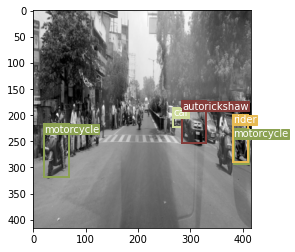

Img23.jpg


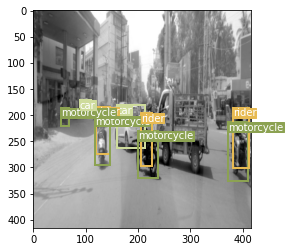

Img12.jpg


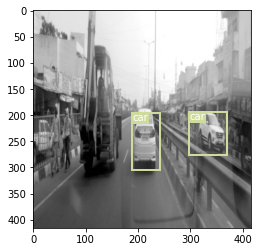

Img36.jpg


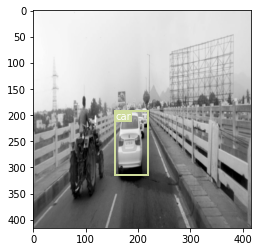

Img38.jpg


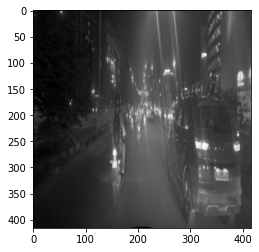

Img7.jpg


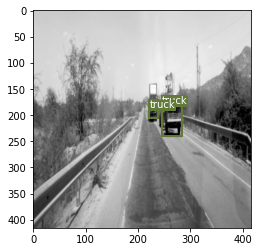

Img35.jpg


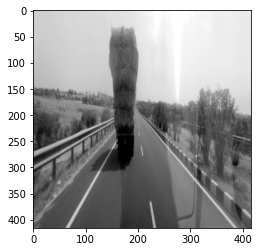

Img21.jpg


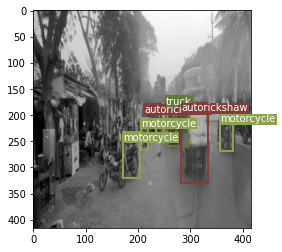

Img4.jpg


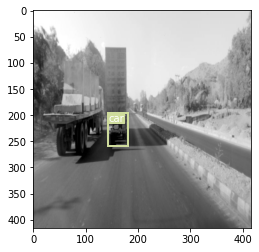

Img31.jpg


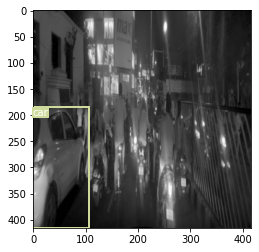

Img8.jpg


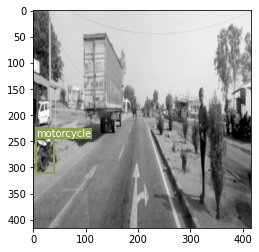

Img22.jpg


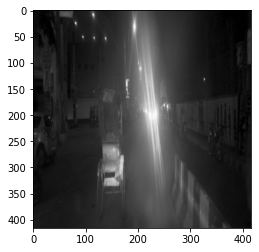

Img19.jpg


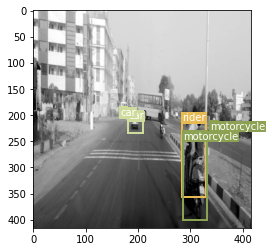

Img17.jpg


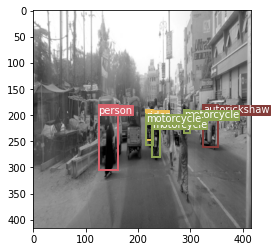

Img15.jpg


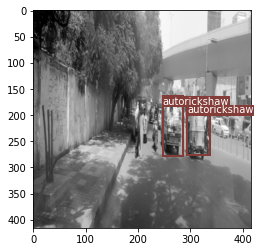

Img5.jpg


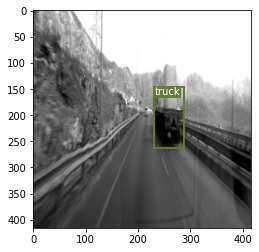

Img37.jpg


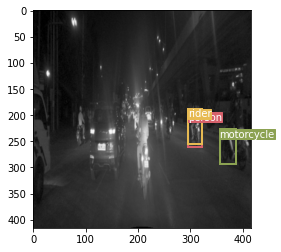

Img10.jpg


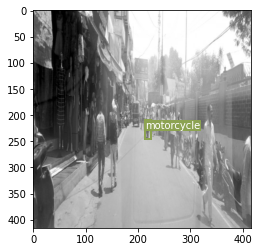

Img9.jpg


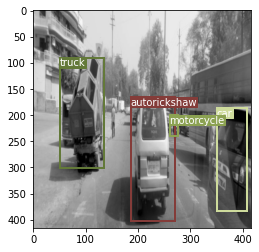

Img3.jpg


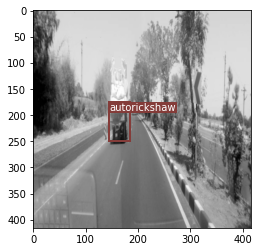

Img2.jpg


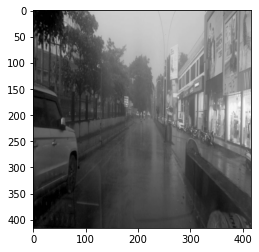

Img28.jpg


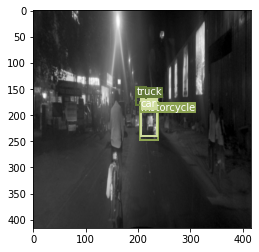

In [60]:
check_point = torch.load(state_dictonary_path)
model.load_state_dict(check_point)


data_transform = transforms.Compose([transforms.Resize((416, 416)), transforms.ToTensor()])
test_images = os.listdir(test_images_path)

f = open('results.csv', 'w')
writer = csv.writer(f)
writer.writerow(['file_name','class','unique_id','coordinates'])
for img in test_images:
    print(img)
    img_path = os.path.join(test_images_path, img)
    image = Image.open(img_path)
    image = data_transform(image).unsqueeze(0).cuda()
    out = model(image)
    for i in range(len(out)):
        out[i] = out[i].to('cpu')
    image.to('cpu')
    bbox = get_boxes(out,anchors, True ) 
    plot_image(image, bbox)
    for box in bbox[0]:
        class_type = classes[int(box[0])]
        b_str = "\'{}\'".format(str(box[2:]))
        fields = [img,class_type, str(int(box[0])), b_str ]
        writer.writerow(fields)

f.close()